In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np


city_daily_temperature_df = pd.read_csv("Datasets/city-daily-temperature.csv")
global_country_info_df = pd.read_csv("Datasets/global-country-information.csv")
print(city_daily_temperature_df.shape)
print(global_country_info_df.shape)

In [3]:
# Preprocessing City Daily Temperature
# We only want to look at data from 2000 onward 
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['Year'] >= 2000]

# Filtering invlaid temperatures
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] <= 134]
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] != -99]

# Formatting the date 
city_daily_temperature_df['Date'] = pd.to_datetime(city_daily_temperature_df[['Year', 'Month', 'Day']], errors='coerce')

# Renaming countries
country_remappings = {
    'Congo': 'Democratic Republic of the Congo', 
    'US': 'United States',
    'The Netherlands' : 'Netherlands',
    'Equador' : 'Ecuador',
    'Myanmar (Burma)' : 'Myanmar',
    'Serbia-Montenegro' : 'Montenegro'
}
city_daily_temperature_df['Country'] = city_daily_temperature_df['Country'].replace(country_remappings)

# Organizing data 
avg_temp_per_year = city_daily_temperature_df.groupby('Year')['AvgTemperature'].mean().reset_index()
avg_temp_per_region_per_year = city_daily_temperature_df.groupby(['Region', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_year = city_daily_temperature_df.groupby(['Country', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_month = city_daily_temperature_df.groupby(['Country', 'Month'])['AvgTemperature'].mean().reset_index()

# Number of countries
# unique_countries = country_groups.keys()
# num_countries = len(unique_countries)

# print("Unique", unique_countries)
# print("Number of countries", num_countries)
# print("Average Temperature Per Year")
# print(avg_temp_per_year)
# print("Average Temperature Per Region by Year")
# print(avg_temp_per_region_per_year)
# print("Average Temperature Per Country by Year") 
# print(avg_temp_per_country_per_year)
# print("Average Temperature Per Country by Month")
# print(avg_temp_per_country_per_month)

In [ ]:
# Preprocessing Global Country Information
# 2023 data
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None)
pd.options.mode.chained_assignment = None

#---------------------DROPPING UNNECESSARY COLUMNS---------------------
global_country_info_df.drop(['Fertility Rate','Population: Labor force participation (%)','Maternal mortality ratio','Unemployment rate','Gross tertiary education enrollment (%)','Gross primary education enrollment (%)','Density\n(P/Km2)','CPI','Abbreviation','Gasoline Price','Armed Forces size','CPI Change (%)','Latitude','Longitude','Tax revenue (%)','Calling Code','Currency-Code','Official language','Total tax rate', 'Physicians per thousand', 'Minimum wage', 'Out of pocket health expenditure',], axis = 1, inplace = True)

#---------------------FIXING COUNTIRES NAME ISSUES---------------------
global_country_info_df.loc[150, ['Country', 'Largest city', 'Capital/Major City']] = ['São Tomé and Príncipe', 'São Tomé', 'São Tomé']
global_country_info_df.loc[176, ['Capital/Major City', 'Largest city']] = ['Nuku\'alofa', 'Nuku\'alofa']
global_country_info_df.loc[181, 'Largest city'] = 'Funafuti'
global_country_info_df.loc[156, ['Capital/Major City', 'Largest city']] = ['Singapore', 'Singapore']
global_country_info_df.loc[97, ['Capital/Major City', 'Largest city']] = ['Tripoli', 'Tripoli']
global_country_info_df.loc[24, 'Largest city'] = 'Bandar Seri Begawan'
global_country_info_df.loc[120, 'Largest city'] = 'Denigomodu'
global_country_info_df.loc[175, ['Capital/Major City', 'Largest city']] = ['Lomé', 'Lomé']
global_country_info_df.loc[37, ['Capital/Major City', 'Largest city']] = ['Bogotá', 'Bogotá']
global_country_info_df.loc[40, ['Capital/Major City', 'Largest city']] = ['San José', 'San José']
global_country_info_df.loc[76, ['Capital/Major City', 'Largest city']] = ['Reykjavík', 'Reykjavík']
global_country_info_df.loc[104, ['Capital/Major City', 'Largest city']] = ['Malé', 'Malé']
global_country_info_df.loc[112, ['Capital/Major City', 'Largest city']] = ['Chișinău', 'Chișinău']
global_country_info_df.loc[23, ['Capital/Major City', 'Largest city']] = ['Brasília', 'São Paulo']
global_country_info_df.loc[31, ['Capital/Major City']] = ['Yaoundé']
global_country_info_df.loc[136, ['Capital/Major City']] = ['Asunción']
global_country_info_df.loc[43, ['Largest city']] = ['Nicosia']
global_country_info_df.loc[168, ['Largest city']] = ['Stockholm']
global_country_info_df.loc[169, ['Largest city']] = ['Zurich']
global_country_info_df.drop([133, 73], inplace=True) # Getting rid of countrys where majority/all of the data is missing

global_country_info_df['Population'] = global_country_info_df['Population'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['GDP'] = global_country_info_df['GDP'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
global_country_info_df['Agricultural Land( %)'] = pd.to_numeric(global_country_info_df['Agricultural Land( %)'].str.replace('%', ''), errors='coerce')
global_country_info_df['Forested Area (%)'] = pd.to_numeric(global_country_info_df['Forested Area (%)'].str.replace('%', ''), errors='coerce')



#---------------------FIXING MISSING CO2-EMMISIONS IN DATAFRAME---------------------
def replace_missing_co2(df):
    for index, row in df[df['Co2-Emissions'].isna()].iterrows():
        closest_country = df.loc[df['Co2-Emissions'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Co2-Emissions'] = closest_row['Co2-Emissions']    
    return df


#---------------------FIXING MISSING BIRTH RATES IN DATAFRAME---------------------
def replace_missing_birth_rate(df):
    for index, row in df[df['Birth Rate'].isna()].iterrows():
        closest_country = df.loc[df['Birth Rate'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  # GDP is now a float
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Birth Rate'] = closest_row['Birth Rate']    
    return df

#---------------------FIXING MISSING URBAN POPULATION IN DATAFRAME---------------------
def replace_missing_urban(df):
    df['Urban_population'] = pd.to_numeric(df['Urban_population'].str.replace(',', ''), errors='coerce')
    for index, row in df[df['Urban_population'].isna()].iterrows():
        closest_country = df.loc[(df['Urban_population'].notna()) &  (df['Urban_population'] < df['Population']) & (df['Population'].notna()) ] 
        if closest_country.empty:
            continue  
        population_diff = closest_country['Population'] - row['Population']
        gdp_diff = closest_country['GDP'] - row['GDP'] 
        combined_diff = population_diff + gdp_diff
        sorted_indices = combined_diff.sort_values().index
        for idx in sorted_indices:
            closest_row = closest_country.loc[idx]
            if closest_row['Urban_population'] < row['Population']:
                df.at[index, 'Urban_population'] = closest_row['Urban_population']
                break
    return df

#---------------------FIXING MISSING LIFE EXPECTANCY IN DATAFRAME---------------------
def replace_missing_life_expectancy(df):
    for index, row in df[df['Life expectancy'].isna()].iterrows():
        closest_country = df.loc[df['Life expectancy'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Life expectancy'] = closest_row['Life expectancy']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_infant_mortality(df):
    for index, row in df[df['Infant mortality'].isna()].iterrows():
        closest_country = df.loc[df['Infant mortality'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Infant mortality'] = closest_row['Infant mortality']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_land(df):
    for index, row in df[df['Agricultural Land( %)'].isna()].iterrows():
        closest_country = df.loc[df['Agricultural Land( %)'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']         
    return df

#---------------------FIXING PERCENTAGES IN DATAFRAME---------------------
def correct_land_percentages(global_country_info_df):
    rows_to_replace = global_country_info_df[(global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) > 100]
    for index, row in rows_to_replace.iterrows():
        closest_country = global_country_info_df.loc[(global_country_info_df['Agricultural Land( %)'].notna()) & (global_country_info_df['Forested Area (%)'].notna()) & (global_country_info_df.index != index) & ((global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) <= 100)]
        population_diff = abs(closest_country['Population'] - row['Population'])
        land_diff = abs((closest_country['Agricultural Land( %)'] + closest_country['Forested Area (%)']) - 100)
        combined_diff = population_diff + land_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        global_country_info_df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        global_country_info_df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']
    return global_country_info_df

global_country_info_df = replace_missing_co2(global_country_info_df)
global_country_info_df = replace_missing_birth_rate(global_country_info_df)
global_country_info_df = replace_missing_urban(global_country_info_df)
global_country_info_df = replace_missing_life_expectancy(global_country_info_df)
global_country_info_df = replace_missing_infant_mortality(global_country_info_df)
global_country_info_df = replace_missing_land(global_country_info_df)
global_country_info_df = correct_land_percentages(global_country_info_df)
global_country_info_df['Land Area(Km2)'] = global_country_info_df['Land Area(Km2)'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Co2-Emissions'] = global_country_info_df['Co2-Emissions'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Urban_population'] = global_country_info_df["Urban_population"].astype(int)
global_country_info_df = global_country_info_df.sort_values(by='Co2-Emissions', ascending=False)
global_country_info_df = global_country_info_df[['Country','Capital/Major City','Largest city','Population','Urban_population','GDP','Land Area(Km2)','Agricultural Land( %)','Forested Area (%)','Birth Rate','Infant mortality','Life expectancy','Co2-Emissions']]
global_country_info_df = global_country_info_df.reset_index(drop=True)
global_country_info_df.index = range(1, len(global_country_info_df) + 1)
global_country_info_df

In [5]:
# Combining the yearly average temperatures by country with the global country information
comined_yearly_df = pd.merge(global_country_info_df, avg_temp_per_country_per_year, on='Country')

In [6]:
# Combining the monthly average temperatures with the global country information
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
combined_monthly_df = pd.merge(global_country_info_df, avg_temp_per_country_per_month, on='Country')
combined_monthly_df['Month'] = combined_monthly_df['Month'].replace(month_dict)

In [7]:
# ANOVA: Country size (small, medium, and large) vs Co2 emissions

p-value: 0.0


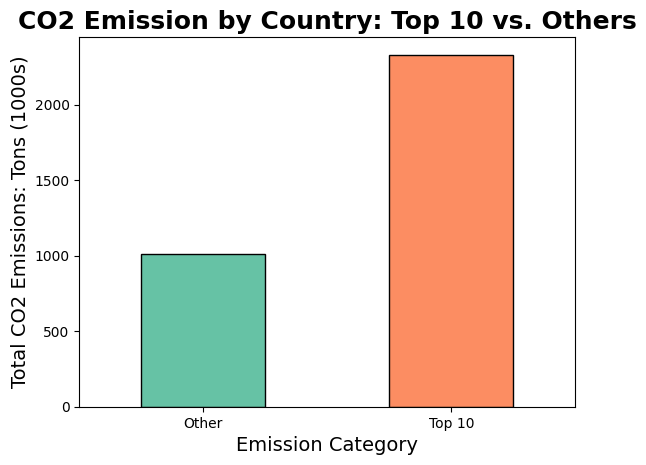

In [15]:
# Chi-Square: Top 10 countries by emission countries compare vs remaining countries
top_10 = global_country_info_df.sort_values(by='Co2-Emissions', ascending=False).head(10)
top_10_list = top_10['Country'].tolist()
global_country_info_df['EmissionCategory'] = global_country_info_df['Country'].apply(lambda x: 'Top 10' if x in top_10_list else 'Other')
merged_df = city_daily_temperature_df.merge(global_country_info_df[['Country', 'EmissionCategory']], on='Country', how='left')

merged_df['TempCategory'] = pd.cut(merged_df['AvgTemperature'], bins=[-np.inf, 10, 25, np.inf], labels=['Low', 'Medium', 'High'])
#merged_df['Co2-Emissions'] = merged_df['Co2-Emissions']/10000
contingency_table = pd.crosstab(merged_df['TempCategory'], merged_df['EmissionCategory'])

# Chi Square Test Result Statistic
from scipy.stats import chi2_contingency
chi2, p, dof,expected = chi2_contingency(contingency_table)
print(f'p-value: {p}')

# Bar Plot comparing CO2 Emissions
emissions_sums = global_country_info_df.groupby('EmissionCategory')['Co2-Emissions'].sum()/10000
emissions_sums.plot(kind='bar', color=['#66c2a5', '#fc8d62'], edgecolor='black')

plt.title('CO2 Emission by Country: Top 10 vs. Others', fontsize=18, weight='bold')
plt.xlabel('Emission Category', fontsize=14)
plt.ylabel('Total CO2 Emissions: Tons (1000s)', fontsize=14)
plt.xticks(rotation=0)
plt.show()

    Summary of Chi-Square
Summary: Our null hypothesis is that the size of a country does not directly influence its Co2 emissions. Our alternate hypothesis is that the size 
of a country does directly influence its CO2 emissions. From our Chi-Square Analysis we can see a **p-value of 0**. Because of these results, we can 
safely assume to reject our null hypothesis and assume that there is a directy influence between our two variables, the top 10 countries and the remaining
countries, with their CO2 emissions. Also, the top 10 countries make over double the Co2 emissions that the rest of the world combined does. From these findings,
we can see that the top 10 countries greatly contribute to Co2 emissions, compared to the rest of the world. 

In [9]:
# Z-Test: Average temperature vs Co2 emissions